# Covid X-Ray Diagnosis
## Machine Learning Final Project
### Enver Kapetanovic & Adrien Ventugol 
### Group 15

In [1]:
#load libraries
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import sklearn
import imblearn

## Data Preprocessing 

In [2]:
#First import the paths of the pictures that we created with DataProcessor.ipynb
paths,paths_org = None,None
# Sort by covid result so we can compare the pixel distribution by test value
paths = pd.read_csv("paths.csv").sort_values(by = "Test", ascending = False).reset_index(drop = True)

In [3]:
#initiate the list we will use to first store the pixel data, then pass into the dataframe.
pixel_data = []

In [4]:
#define a processing function to obtain transformed pixel data from the paths of the images
def to_pixel(row):
    color_img = Image.open(row["image_path"])
    resized = color_img.resize((50, 50), Image.BICUBIC) #Bicubic/Nearest resample give the best results
    sharpened = ImageEnhance.Sharpness(resized).enhance(1.5)
    contrasted = ImageEnhance.Contrast(sharpened).enhance(1.1)
    gray_img = ImageOps.grayscale(contrasted)
    pixel_data.append(np.asarray(gray_img).flatten().tolist()) #convert image to numpy array, flatten it, convert to list
    color_img.close()
    # pixel data now has the complete data of another picture at pixel_data[-1]

In [5]:
#apply use the functions as lambdas to apply to all the rows
paths.apply(lambda row: to_pixel(row), axis = 1)

#Separate Data into X and y
y = paths.loc[0:,'Test']
X = pd.DataFrame(data = pixel_data)

In [6]:
#check y
paths.loc[paths["Test"] == 0]

,image_path,Test
184,data_upload_v2/test/non/Lung_Opacity/patient00...,0
185,data_upload_v2/test/non/Lung_Opacity/patient00...,0
186,data_upload_v2/test/non/Lung_Opacity/patient00...,0
187,data_upload_v2/test/non/Lung_Opacity/patient00...,0
188,data_upload_v2/test/non/Lung_Opacity/patient00...,0
...,...,...
3759,data_upload_v2/test/non/No_Finding/patient0901...,0
3760,data_upload_v2/test/non/No_Finding/patient0615...,0
3761,data_upload_v2/test/non/No_Finding/patient0773...,0
3762,data_upload_v2/test/non/No_Finding/patient0222...,0


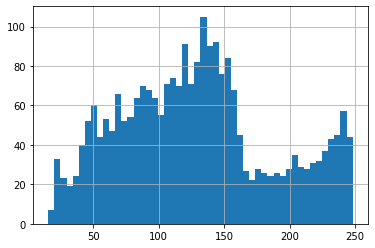

In [7]:
# rows 184 to 3763 contain the non-covid samples
#Let's check the difference in pixel distribution after processing
X.loc[184:3763, :].mean().transpose().hist(bins = 50)

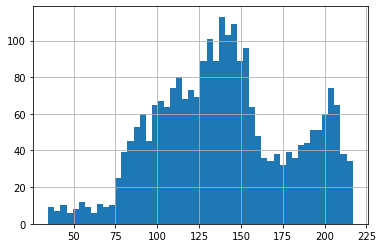

In [8]:
X.loc[0:183, :].mean().transpose().hist(bins = 50)

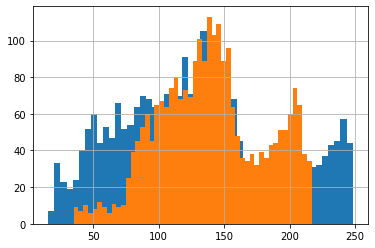

In [9]:
X.loc[184:3763, :].mean().transpose().hist(bins = 50)
X.loc[0:183, :].mean().transpose().hist(bins = 50)

In [10]:
#Most of the difference is situated in the number of pixels from ~~20 to ~~100 and ~~220 to ~~250
#Train/test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, train_size=.8, random_state=0)

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [12]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [16]:
y_score_test = lr.predict(X_test)
#metrics we are interested in
av_prec = sk_mtrx.average_precision_score(y_test, y_score_test)

#for this model we are particularly interested in maximizing recall at the detriment of precision
recall = sk_mtrx.recall_score(y_test, y_score_test, average = None)
bal_acc = sk_mtrx.balanced_accuracy_score(y_test,y_score_test)
conf = sk_mtrx.confusion_matrix(y_test, y_score_test)
f1 = sk_mtrx.f1_score(y_test, y_score_test)


print("test set:")
print(("recall score:\t\t{0}\nbalanced accuracy score: {1}\n confusion matrix:\n{2}\n"+
"f1 score: \t\t{3}").format(recall, bal_acc, conf,f1))


sk_mtrx.plot_roc_curve(lr, X_test, y_test)
plt.grid()

NameError: name 'sk_mtrx' is not defined

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[691  28]
 [ 10  24]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       719
           1       0.46      0.71      0.56        34

    accuracy                           0.95       753
   macro avg       0.72      0.83      0.77       753
weighted avg       0.96      0.95      0.95       753



In [14]:
y_pred = lr.predict(X_test)

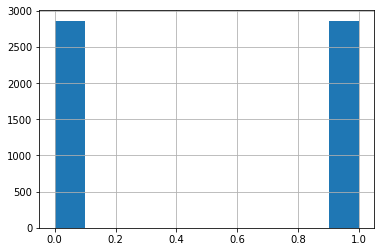

## Naive Bayes

In [12]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

#Normalize X using mean normalization. Minmax could partly negate the difference we've introduced earlier.
X_norm = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)


array([[-2.55144920e-01, -3.34395887e-01, -2.08366719e-01, ...,
        -1.50988178e-01, -8.12375630e-01, -7.46900775e-01],
       [-5.55797049e-01, -4.84979417e-01, -4.91682632e-01, ...,
        -9.67658295e-01, -8.12375630e-01, -7.46900775e-01],
       [ 3.67212352e+00,  3.45170429e+00,  2.88631479e+00, ...,
         9.25531520e-01,  1.47830015e-01, -6.35559232e-01],
       ...,
       [-4.61843259e-01, -3.55907820e-01, -3.60921442e-01, ...,
        -9.55284505e-01, -6.90659421e-01, -6.21641539e-01],
       [ 7.92569338e-03, -7.62526932e-02, -1.22249336e-02, ...,
         2.32599300e-01, -9.34240059e-04,  7.42431028e-02],
       [-5.55797049e-01, -4.84979417e-01, -4.91682632e-01, ...,
        -9.67658295e-01, -8.12375630e-01, -7.46900775e-01]])

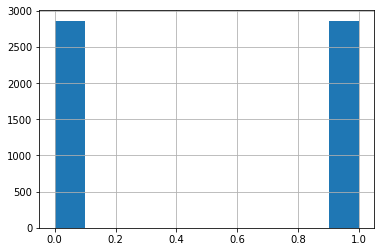

In [13]:
#Imbalanced Data, Solve with Random Over Sampling Technique
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 3)

#In this current setup, oversampling reduces the number of False Negatives.
X_train,y_train = ros.fit_resample(X_norm,y_train)
y_train.hist()

In [14]:
from sklearn.naive_bayes import BernoulliNB
import sklearn.metrics as sk_mtrx

In [21]:
#train the model
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB()

test set:
recall score:		[0.95132128 0.94117647]
balanced accuracy score: 0.9462488750715863
 confusion matrix:
[[684  35]
 [  2  32]]
f1 score: 		0.6336633663366337


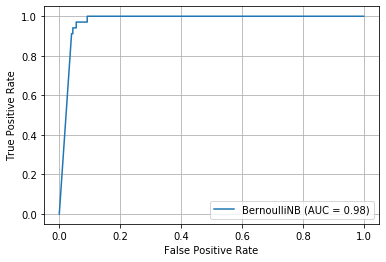

In [22]:
y_score_test = clf.predict(X_test)
#metrics we are interested in
av_prec = sk_mtrx.average_precision_score(y_test, y_score_test)

#for this model we are particularly interested in maximizing recall at the detriment of precision
recall = sk_mtrx.recall_score(y_test, y_score_test, average = None)
bal_acc = sk_mtrx.balanced_accuracy_score(y_test,y_score_test)
conf = sk_mtrx.confusion_matrix(y_test, y_score_test)
f1 = sk_mtrx.f1_score(y_test, y_score_test)


print("test set:")
print(("recall score:\t\t{0}\nbalanced accuracy score: {1}\n confusion matrix:\n{2}\n"+
"f1 score: \t\t{3}").format(recall, bal_acc, conf,f1))


sk_mtrx.plot_roc_curve(clf, X_test, y_test)
plt.grid()

0.45217316277762815

Text(0.5, 1.0, '2-class Precision-Recall curve:Average Precision =0.45')

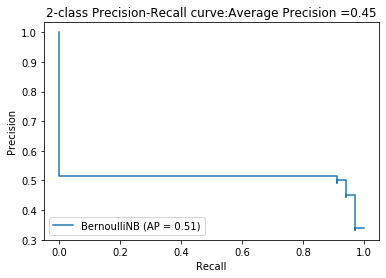

In [20]:
disp = sk_mtrx.plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve:Average Precision ={0:0.2f}'.format(av_prec))

## Let's try our model on pictures!
### Feel free to load your own pictures on the last line

In [17]:
cov = "Demo\\covid-demo.jpg"
non = "Demo\\normal-demo.jpg"

In [18]:
def test_model(path):
    pic = Image.open(path)
    pic.show()
    resized = pic.resize((50, 50), Image.BICUBIC)
    sharpened = ImageEnhance.Sharpness(resized).enhance(1.5)
    contrasted = ImageEnhance.Contrast(sharpened).enhance(1.1)
    gray_img = ImageOps.grayscale(contrasted)
    covid_pixels = np.asarray(gray_img).flatten()
    pic.close()
    covid_pixels = pd.DataFrame(data = covid_pixels).transpose()
    covid_pixels = std_scaler.transform(covid_pixels)
    if clf.predict(covid_pixels)[0] == 1:
        print("The patient has covid.")
    else:
        print("The patient does not have covid.")

In [19]:
for pic in [cov,non]:
    test_model(pic)

The patient has covid.
The patient does not have covid.


In [21]:
#Your turn!
#test_model(...)

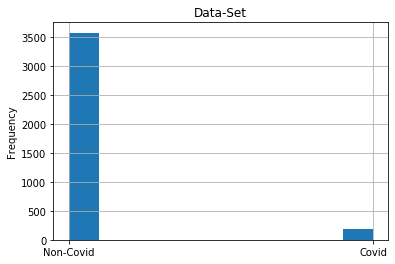

In [17]:
y.hist()
plt.title('Data-Set')
plt.ylabel('Frequency') 
positions = (0, 1)
labels = ("Non-Covid", "Covid")
plt.xticks(positions, labels)
plt.savefig('data.jpg')